Classification Problem
https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501

- Logistic 


In [148]:
# Utility
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dython.nominal import identify_nominal_columns, associations
from sklearn.model_selection import train_test_split ,StratifiedKFold
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lazypredict.Supervised import LazyClassifier
import time
from lightgbm import LGBMClassifier
import lazypredict



# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

root_dir = "input"
seed = 40

RANDOM_STATE = 12 
FOLDS = 5
STRATEGY = 'median'

In [149]:
# Show me what we have
os.listdir(root_dir)

['sample_submission.csv', 'test.csv', 'train.csv']

In [150]:
# Load all the data
train = pd.read_csv(root_dir + "/train.csv")
test = pd.read_csv(root_dir + "/test.csv")
submission = pd.read_csv(root_dir + "/sample_submission.csv")


In [151]:
print(train.info())
print(test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

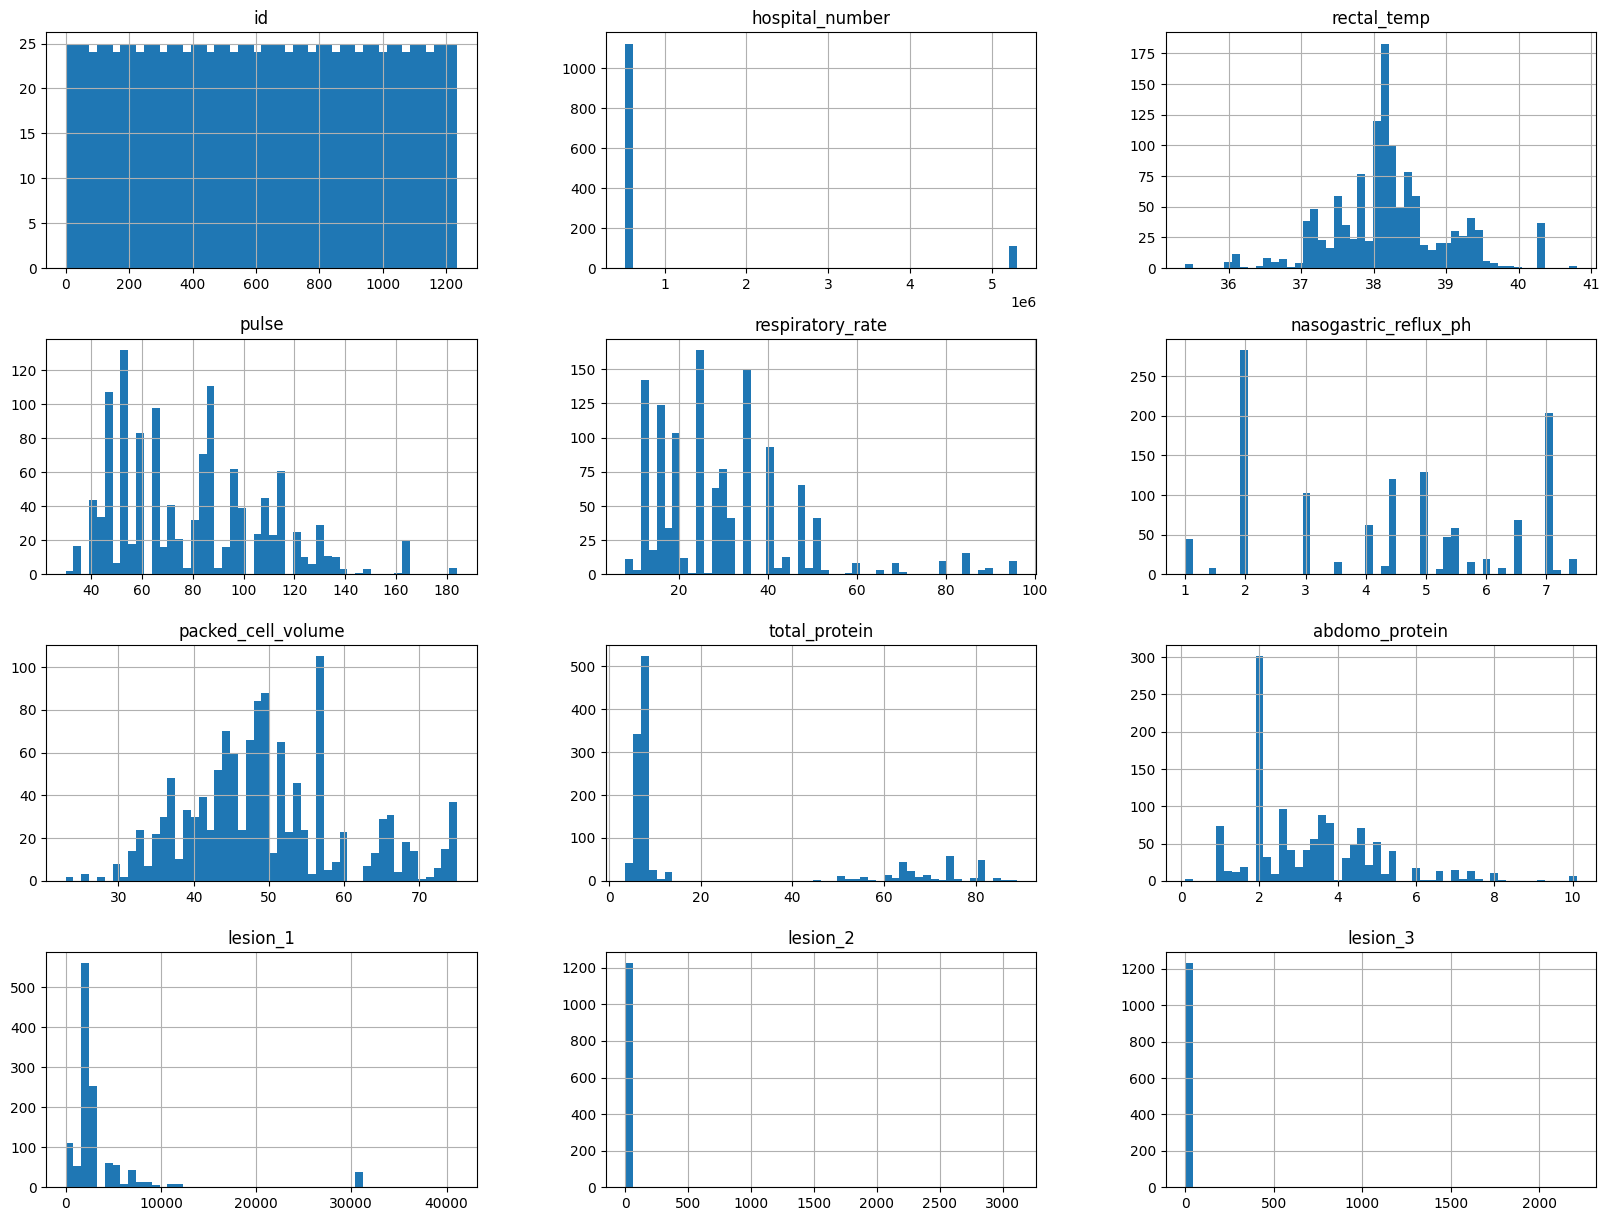

In [152]:
# only float values
train.hist(bins=50, figsize=(20,15))
plt.show()

array([[<Axes: xlabel='id', ylabel='id'>,
        <Axes: xlabel='hospital_number', ylabel='id'>,
        <Axes: xlabel='rectal_temp', ylabel='id'>,
        <Axes: xlabel='pulse', ylabel='id'>,
        <Axes: xlabel='respiratory_rate', ylabel='id'>,
        <Axes: xlabel='nasogastric_reflux_ph', ylabel='id'>,
        <Axes: xlabel='packed_cell_volume', ylabel='id'>,
        <Axes: xlabel='total_protein', ylabel='id'>,
        <Axes: xlabel='abdomo_protein', ylabel='id'>,
        <Axes: xlabel='lesion_1', ylabel='id'>,
        <Axes: xlabel='lesion_2', ylabel='id'>,
        <Axes: xlabel='lesion_3', ylabel='id'>],
       [<Axes: xlabel='id', ylabel='hospital_number'>,
        <Axes: xlabel='hospital_number', ylabel='hospital_number'>,
        <Axes: xlabel='rectal_temp', ylabel='hospital_number'>,
        <Axes: xlabel='pulse', ylabel='hospital_number'>,
        <Axes: xlabel='respiratory_rate', ylabel='hospital_number'>,
        <Axes: xlabel='nasogastric_reflux_ph', ylabel='hospital_nu

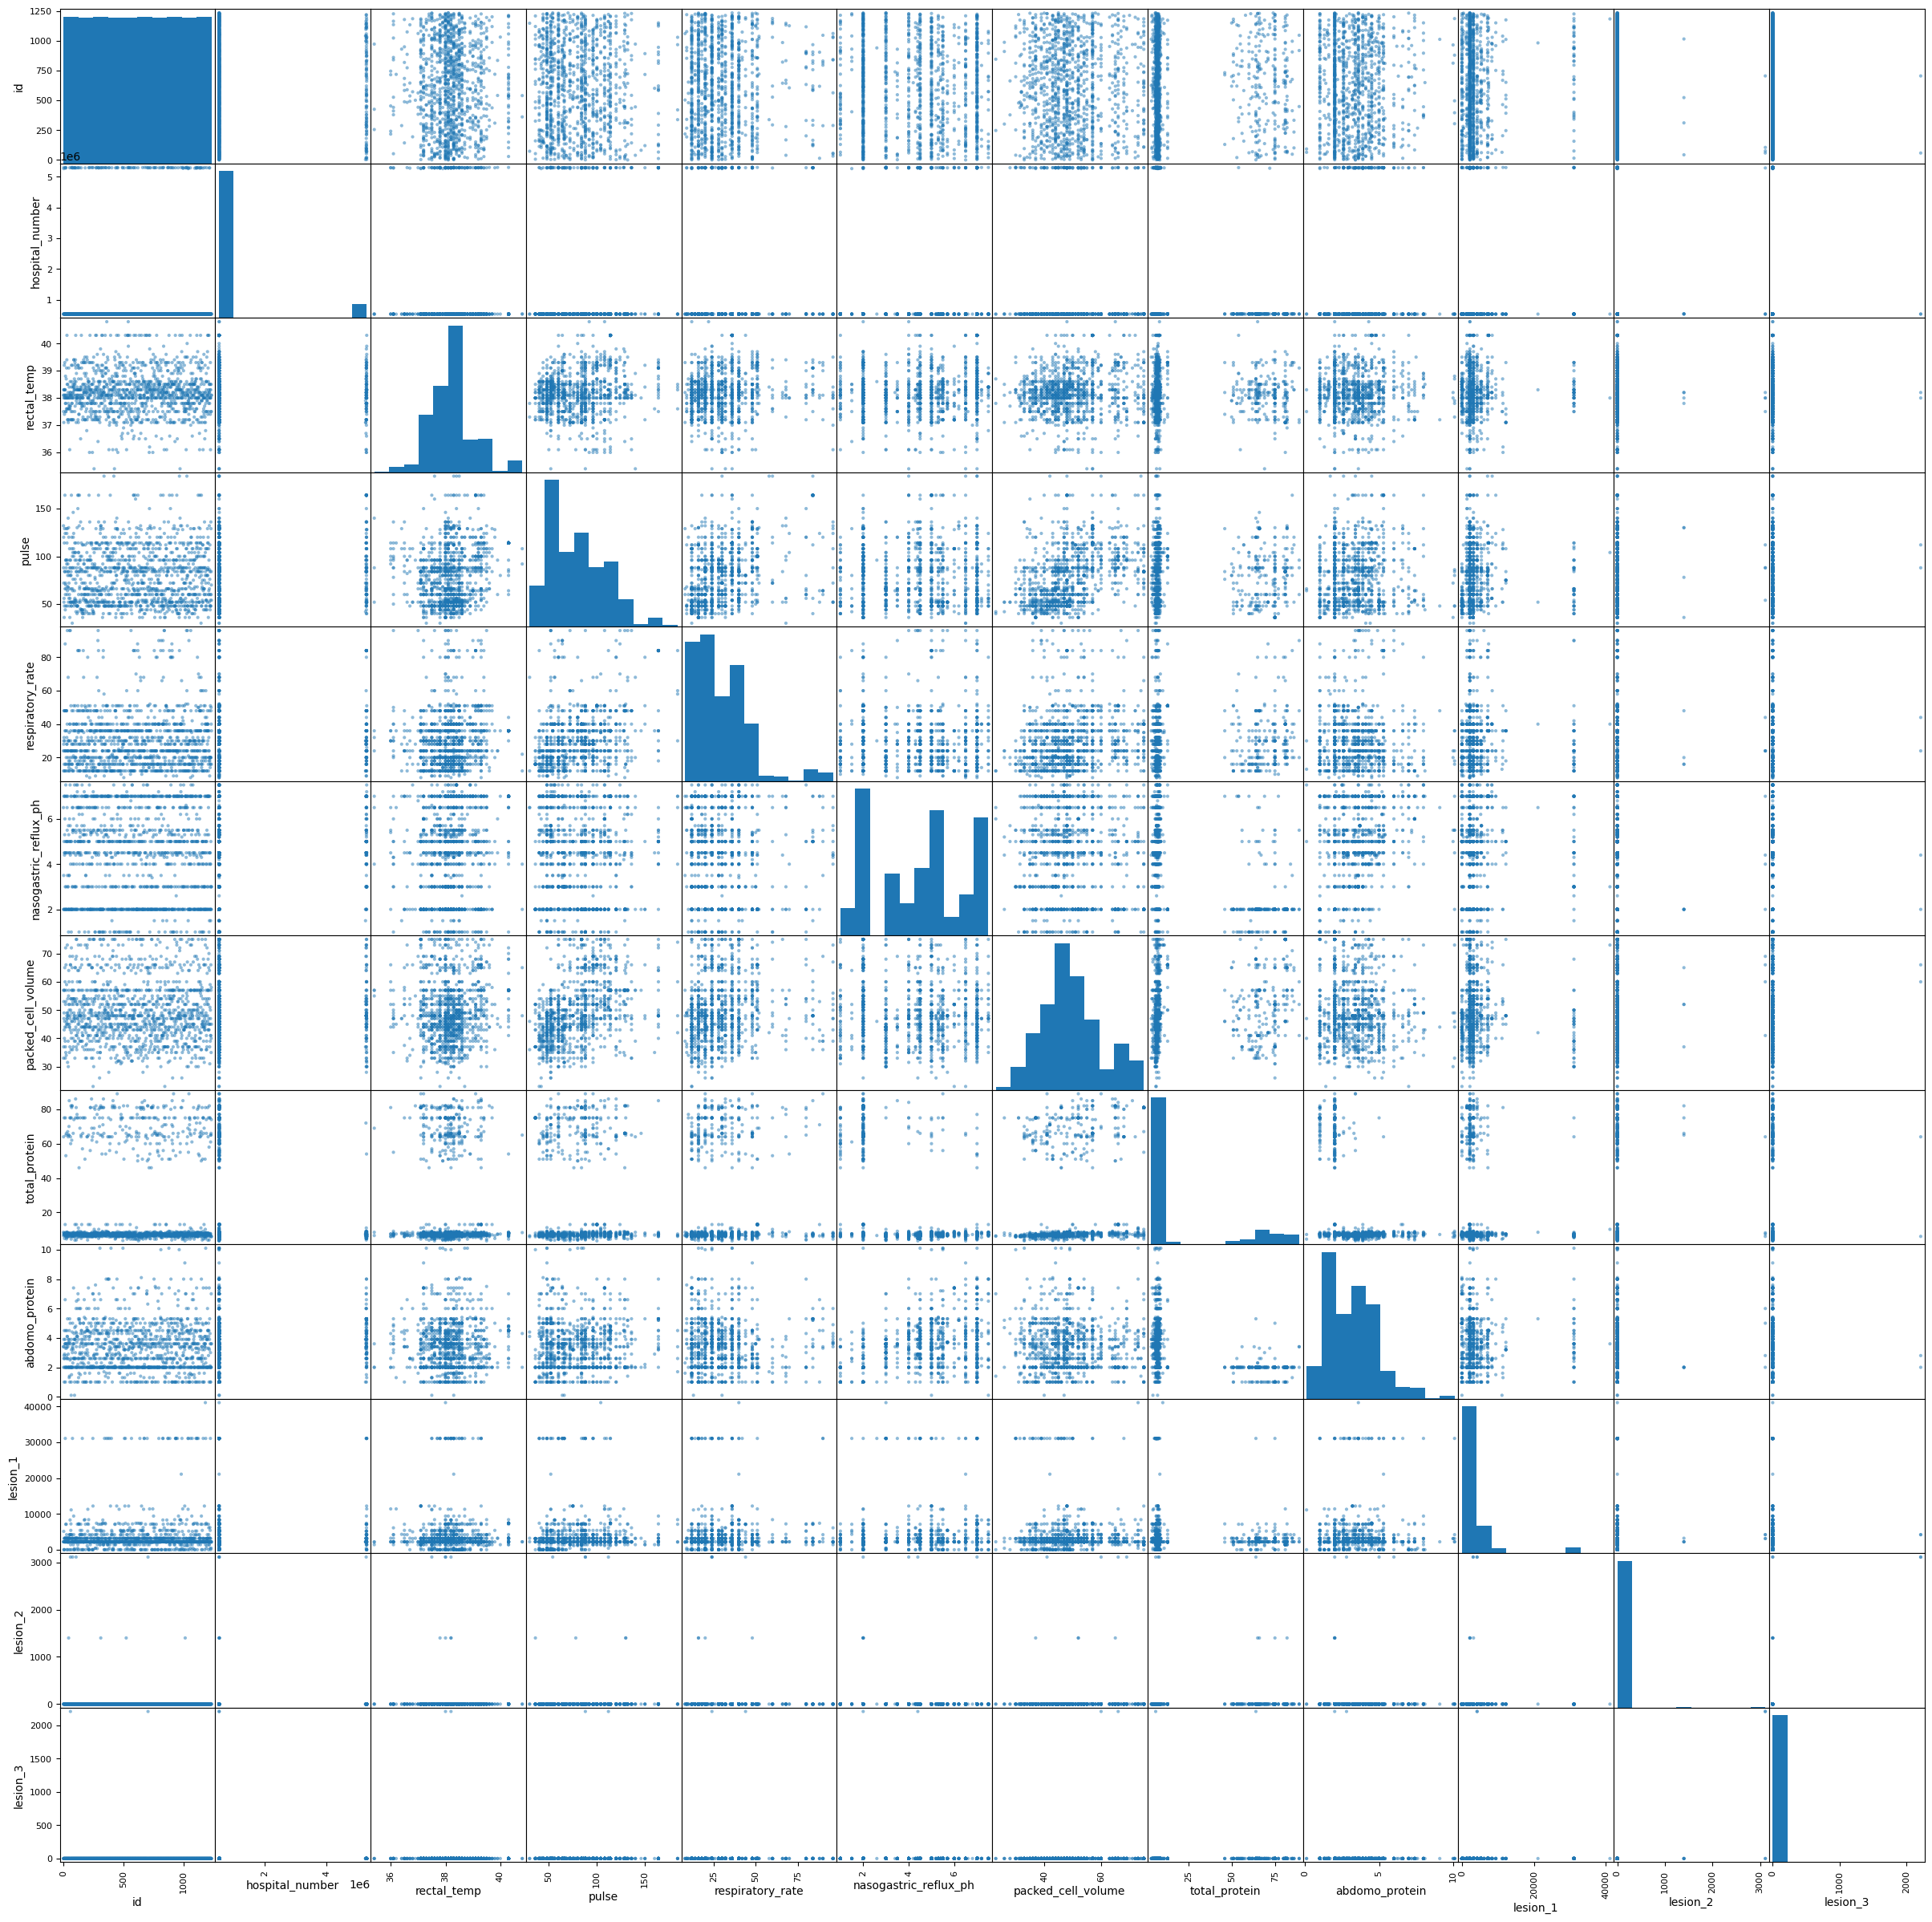

In [153]:
pd.plotting.scatter_matrix(train, figsize=(30,30))

In [154]:
# Hist also for the categories
# Plot interesting features together (from correlation plot)
# Delete NaN values
# delete zeros values


Now start to understand the columns and the data.

What is normal for a horse?
https://canberraequinehospital.com.au/vital-signs-adult-horse/

- Heart rate 38-44 beats per minute
- Rectal temperature 37-38.5ºC
- Respiratory (breathing) rate 12-20 breaths per minute
- Gums should be light pink and moist, and capillary refill time less than 2 seconds
- Sounds of the intestines should be heard on both sides of the abdomen
- 6-10 manures and 3-4 urinations should be passed every 24 hours
- A 500kg thoroughbred-sized horse drinks 20-25 litres every 24 hours


https://www.midcoastequine.com/normal-vital-signs
Addult: Heart Rate 28-44, Respiratory 10-24
Foals: Heart Rate 80-100 bpm, Respiratory 20-40bpm



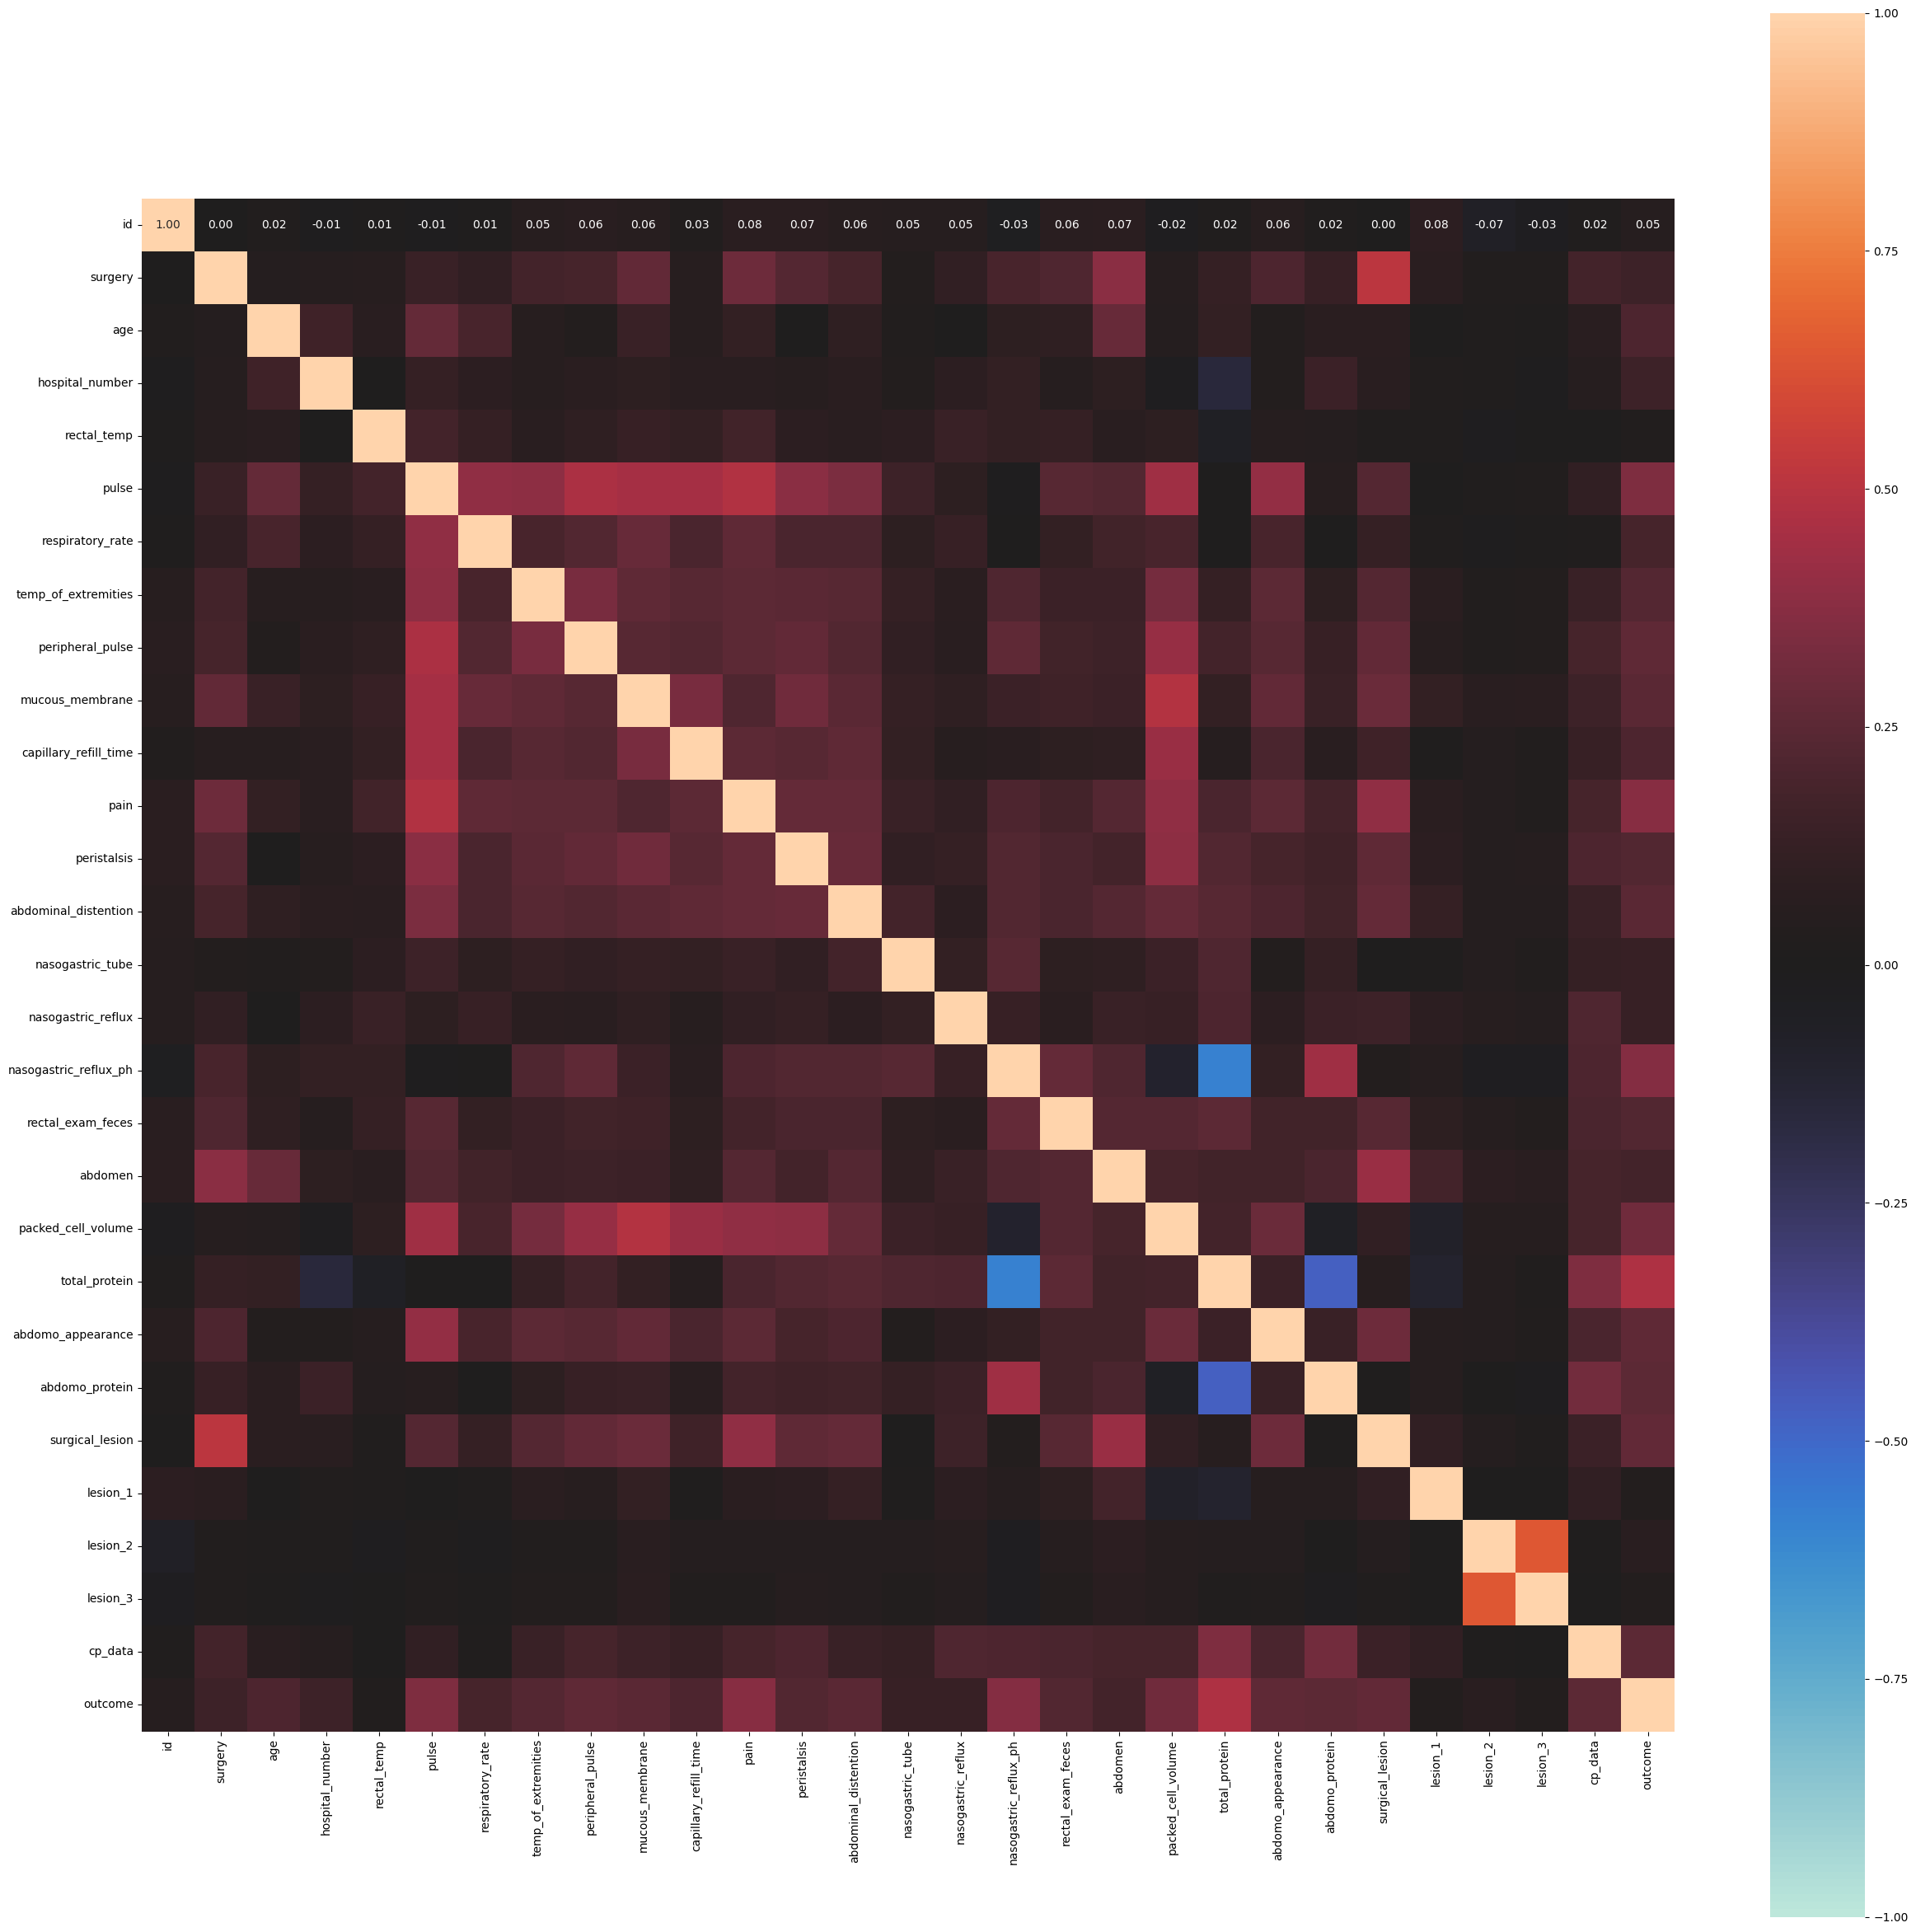

In [155]:
# Fast Correleation matrix 
categorical_features=identify_nominal_columns(train)
complete_correlation= associations(train, figsize=(30,30))

pulse, pain, nasogastric_reflux, packed_cell_volume, total_protein
This categories are quite correlated with the output.

In [156]:
train.drop(["id"] , axis = 1 , inplace = True)
test.drop(["id"] , axis = 1 , inplace = True)
TARGET = 'outcome'
train.drop(["hospital_number" ,"peripheral_pulse", "mucous_membrane" , "capillary_refill_time", "abdomo_appearance" , "surgical_lesion", "surgery", "age" , "temp_of_extremities", "peristalsis" , "abdominal_distention" , "nasogastric_tube" , "rectal_exam_feces" , "abdomen" , "cp_data" , "lesion_1" , "lesion_2" , "lesion_3"] , axis = 1 ,inplace = True)
test.drop(["hospital_number" ,"peripheral_pulse", "mucous_membrane", "capillary_refill_time" , "abdomo_appearance" , "surgical_lesion", "surgery", "age" , "temp_of_extremities", "peristalsis" , "abdominal_distention" , "nasogastric_tube" , "rectal_exam_feces" , "abdomen" , "cp_data" , "lesion_1" , "lesion_2" , "lesion_3"] , axis = 1 ,inplace = True)


In [157]:


# Encoding Categories
label_cols = ["pulse", "pain","nasogastric_reflux", "packed_cell_volume" ,"total_protein"]
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train ,test = label_encoder(train,test ,label_cols)


In [158]:
X = train.drop(TARGET , axis =1 )
y = train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =824)


In [159]:
X_train.head()

,rectal_temp,pulse,respiratory_rate,pain,nasogastric_reflux,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein
336,38.20,29,12.00,3,1,5.20,23,53,3.30
929,37.50,26,28.00,3,1,3.50,7,28,3.60
126,38.70,32,18.00,3,1,5.50,24,50,1.30
48,38.40,41,35.00,3,0,3.50,25,78,1.30
661,37.80,37,30.00,2,1,2.00,27,62,2.00


In [160]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 411 entries, 336 to 432
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   rectal_temp            411 non-null    float64
 1   pulse                  411 non-null    int32  
 2   respiratory_rate       411 non-null    float64
 3   pain                   411 non-null    int32  
 4   nasogastric_reflux     411 non-null    int32  
 5   nasogastric_reflux_ph  411 non-null    float64
 6   packed_cell_volume     411 non-null    int32  
 7   total_protein          411 non-null    int32  
 8   abdomo_protein         411 non-null    float64
dtypes: float64(4), int32(5)
memory usage: 24.1 KB


In [161]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=12,
                     classifiers='all')

models, predictions = clf.fit(X_train , X_test , y_train , y_test)


100%|██████████| 29/29 [00:00<00:00, 29.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 411, number of used features: 9
[LightGBM] [Info] Start training from score -1.182311
[LightGBM] [Info] Start training from score -1.587776
[LightGBM] [Info] Start training from score -0.715288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [162]:
models[:15]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.66,0.65,None,0.66,0.17
LGBMClassifier,0.65,0.64,None,0.65,0.10
ExtraTreesClassifier,0.65,0.64,None,0.65,0.14
BaggingClassifier,0.63,0.63,None,0.63,0.04
GaussianNB,0.63,0.61,None,0.63,0.01
SVC,0.65,0.60,None,0.64,0.04
NearestCentroid,0.58,0.60,None,0.58,0.01
NuSVC,0.63,0.59,None,0.62,0.04
QuadraticDiscriminantAnalysis,0.61,0.59,None,0.61,0.01


In [163]:
lgb_params = {
    'objective' : 'multiclass',
    #'n_estimators' :50,
    'learning_rate' : 0.08
}

lgb_predictions = 0
lgb_scores = []
lgb_fimp = []
LGBM_FEATURES = list(train.columns)[:-1]
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)



lgbm = LGBMClassifier() # Shortname the LGBMClassifier()

lgbm.fit(X_train, y_train) # Train the lgbm on train sets

lgbm_tuned = LGBMClassifier(boosting_type = 'gbdt',
                            class_weight = None,
                            min_child_samples = 20,
                            num_leaves = 30,
                            subsample_for_bin = 20000,
                            learning_rate=0.01, 
                            max_depth=10, 
                            n_estimators=40, 
                            colsample_bytree=0.6) # LightGBM Classifier with optimum paramteres
lgbm_tuned.fit(X_train, y_train) #Fit the model with the optimum parameters

y_test_pred = lgbm_tuned.predict(X_test)




"""

#Converting the dataset in proper LGB format
d_train=LGBMClassifier.Dataset(X_train, label=y_train)



for fold, (train_idx, valid_idx) in enumerate(skf.split(train[LGBM_FEATURES], train[TARGET])):
    print(f'\033[94m')
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][LGBM_FEATURES], train.iloc[valid_idx][LGBM_FEATURES]
    y_train , y_valid = train[TARGET].iloc[train_idx] , train[TARGET].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train)
    
    preds_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid,  preds_valid)
    lgb_scores.append(acc)
    run_time = time.time() - start_time
    
    fim = pd.DataFrame(index=LGBM_FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    
    print(f"Fold={fold+1}, Accuracy score: {acc:.2f}%, Run Time: {run_time:.2f}s")
    test_preds = model.predict(test[LGBM_FEATURES]) 
    print(type(test_preds))
    print(type(FOLDS))
    print(type(lgb_predictions))
    lgb_predictions += test_preds/FOLDS
    print('test')
print("")
print("Mean Accuracy :", np.mean(lgb_scores))
"""

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 411, number of used features: 9
[LightGBM] [Info] Start training from score -1.182311
[LightGBM] [Info] Start training from score -1.587776
[LightGBM] [Info] Start training from score -0.715288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

'\n\n#Converting the dataset in proper LGB format\nd_train=LGBMClassifier.Dataset(X_train, label=y_train)\n\n\n\nfor fold, (train_idx, valid_idx) in enumerate(skf.split(train[LGBM_FEATURES], train[TARGET])):\n    print(f\'\x1b\')\n    print(10*"=", f"Fold={fold+1}", 10*"=")\n    start_time = time.time()\n    \n    X_train, X_valid = train.iloc[train_idx][LGBM_FEATURES], train.iloc[valid_idx][LGBM_FEATURES]\n    y_train , y_valid = train[TARGET].iloc[train_idx] , train[TARGET].iloc[valid_idx]\n    \n    model = LGBMClassifier(**lgb_params)\n    model.fit(X_train, y_train)\n    \n    preds_valid = model.predict(X_valid)\n    acc = accuracy_score(y_valid,  preds_valid)\n    lgb_scores.append(acc)\n    run_time = time.time() - start_time\n    \n    fim = pd.DataFrame(index=LGBM_FEATURES,\n                 data=model.feature_importances_,\n                 columns=[f\'{fold}_importance\'])\n    lgb_fimp.append(fim)\n    \n    print(f"Fold={fold+1}, Accuracy score: {acc:.2f}%, Run Time: {run

In [164]:
#new = np.concatenate((y_test_pred, y_test))

#np.savetxt("foo.csv", y_test_pred, delimiter=",")

In [165]:
"""lgb_predictions = y_test_pred
submission[TARGET] = lgb_predictions
submission.to_csv("submission.csv",index=False)
submission.head()"""

'lgb_predictions = y_test_pred\nsubmission[TARGET] = lgb_predictions\nsubmission.to_csv("submission.csv",index=False)\nsubmission.head()'

In [166]:
"""
X_train = X_train.select_dtypes(include=[object])
X_train.head(3)
X_train.columns
le = LabelEncoder()

X_2 = X_train.apply(le.fit_transform)
X_2.head()
enc = OneHotEncoder()

# 2. FIT
enc.fit(X_2)

# 3. Transform
onehotlabels = enc.transform(X_2).toarray()
onehotlabels.shape

onehotlabels
type(onehotlabels)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train)
enc.categories_[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]"""

"\nX_train = X_train.select_dtypes(include=[object])\nX_train.head(3)\nX_train.columns\nle = LabelEncoder()\n\nX_2 = X_train.apply(le.fit_transform)\nX_2.head()\nenc = OneHotEncoder()\n\n# 2. FIT\nenc.fit(X_2)\n\n# 3. Transform\nonehotlabels = enc.transform(X_2).toarray()\nonehotlabels.shape\n\nonehotlabels\ntype(onehotlabels)\nenc = OneHotEncoder(handle_unknown='ignore')\nenc.fit(X_train)\nenc.categories_[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]"

In [167]:
"""

# Indentify numerical and categorical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
X_train = ct.fit_transform(X_train)


# Print new shape
print('Training set shape:', X_train.shape)
"""

'\n\n# Indentify numerical and categorical columns\nnumerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in [\'int64\', \'float64\']]\ncategorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]\n\n# Scale numerical data to have mean=0 and variance=1\nnumerical_transformer = Pipeline(steps=[(\'scaler\', StandardScaler())])\n\n# One-hot encode categorical data\ncategorical_transformer = Pipeline(steps=[(\'onehot\', OneHotEncoder(drop=\'if_binary\', handle_unknown=\'ignore\',sparse=False))])\n\n# Combine preprocessing\nct = ColumnTransformer(\n    transformers=[\n        (\'num\', numerical_transformer, numerical_cols),\n        (\'cat\', categorical_transformer, categorical_cols)],\n        remainder=\'passthrough\')\n\n# Apply preprocessing\nX_train = ct.fit_transform(X_train)\n\n\n# Print new shape\nprint(\'Training set shape:\', X_train.shape)\n'

In [168]:
"""
# Indentify numerical and categorical columns
numerical_cols_test = [cname for cname in X_test.columns if X_test[cname].dtype in ['int64', 'float64']]
categorical_cols_test = [cname for cname in X_test.columns if X_test[cname].dtype == "object"]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer_test = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer_test = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct_test = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_test, numerical_cols_test),
        ('cat', categorical_transformer_test, categorical_cols_test)],
        remainder='passthrough')

# Apply preprocessing
#X_test = ct_test.fit_transform(X_test)
X_test = ct.transform(X_test)

# Print new shape
print('Training set shape:', X_test.shape)
"""

'\n# Indentify numerical and categorical columns\nnumerical_cols_test = [cname for cname in X_test.columns if X_test[cname].dtype in [\'int64\', \'float64\']]\ncategorical_cols_test = [cname for cname in X_test.columns if X_test[cname].dtype == "object"]\n\n# Scale numerical data to have mean=0 and variance=1\nnumerical_transformer_test = Pipeline(steps=[(\'scaler\', StandardScaler())])\n\n# One-hot encode categorical data\ncategorical_transformer_test = Pipeline(steps=[(\'onehot\', OneHotEncoder(drop=\'if_binary\', handle_unknown=\'ignore\',sparse=False))])\n\n# Combine preprocessing\nct_test = ColumnTransformer(\n    transformers=[\n        (\'num\', numerical_transformer_test, numerical_cols_test),\n        (\'cat\', categorical_transformer_test, categorical_cols_test)],\n        remainder=\'passthrough\')\n\n# Apply preprocessing\n#X_test = ct_test.fit_transform(X_test)\nX_test = ct.transform(X_test)\n\n# Print new shape\nprint(\'Training set shape:\', X_test.shape)\n'

In [169]:
"""
# building the all models
model_1 = RandomForestClassifier(random_state=seed)
model_2 = LogisticRegression(random_state=seed, max_iter=1000)
model_3 = SGDClassifier(random_state=seed)

# training
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)

# predicting
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
"""

'\n# building the all models\nmodel_1 = RandomForestClassifier(random_state=seed)\nmodel_2 = LogisticRegression(random_state=seed, max_iter=1000)\nmodel_3 = SGDClassifier(random_state=seed)\n\n# training\nmodel_1.fit(X_train, y_train)\nmodel_2.fit(X_train, y_train)\nmodel_3.fit(X_train, y_train)\n\n# predicting\npred_1 = model_1.predict(X_test)\npred_2 = model_2.predict(X_test)\npred_3 = model_3.predict(X_test)\n'

In [172]:
y_test_df = pd.DataFrame()
y_test_df = y_test

In [174]:
y_test_df.to_csv("y_test_df.csv")

In [176]:
y_test_pred_df = pd.DataFrame(y_test_pred)
y_test_pred_df.to_csv("y_test_pred.csv")